## Installing Modules

In [1]:
!pip install spacy==3
!python -m spacy download en_core_web_sm
!pip install pytorch_lightning torchmetrics tableprint


     |████████████████████████████████| 12.7MB 221kB/s 
     |████████████████████████████████| 460kB 35.1MB/s 
     |████████████████████████████████| 9.1MB 32.5MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
     |████████████████████████████████| 624kB 34.4MB/s 
     |████████████████████████████████| 122kB 34.1MB/s 
  Created wheel for smart-open: filename=smart_open-3.0.0-cp37-none-any.whl size=107107 sha256=d280ba774459f17a85d879807a9860c7a8b8776bd5a458118ba7bdfac34dfba5
  Stored in directory: /root/.cache/pip/wheels/18/88/7c/f06dabd5e9cabe02d2269167bcacbbf9b47d0c0ff7d6ebcb78
Successfully built smart-open
  Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Found existing installation: smart-open 5.1.0
    Uninstalling smart-open-5.1.0:
      Successfully uninstalled smart-open-

## Imports

In [2]:
# Import Library
import random
import torch, torchtext
# from torchtext.legacy import data 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


import pandas as pd
import sys, os, pickle
import numpy as np
import math
import matplotlib.pyplot  as plt

import spacy

import pytorch_lightning as pl
import torchmetrics

from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import tableprint as tp

import collections
import re
from torchtext.vocab import vocab

# Manual Seed
SEED = 43
torch.manual_seed(SEED)

## Loading Data

Cornell Movie--Dialogs Corpus
https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html

In [3]:
!wget http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip

--2021-06-21 10:11:45--  http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.36
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9916637 (9.5M) [application/zip]
Saving to: ‘cornell_movie_dialogs_corpus.zip’

cornell_movie_dialo 100%[===================>]   9.46M  11.1MB/s    in 0.9s    

2021-06-21 10:11:46 (11.1 MB/s) - ‘cornell_movie_dialogs_corpus.zip’ saved [9916637/9916637]



In [4]:
!unzip cornell_movie_dialogs_corpus

Archive:  cornell_movie_dialogs_corpus.zip
   creating: cornell movie-dialogs corpus/
  inflating: cornell movie-dialogs corpus/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/cornell movie-dialogs corpus/
  inflating: __MACOSX/cornell movie-dialogs corpus/._.DS_Store  
  inflating: cornell movie-dialogs corpus/chameleons.pdf  
  inflating: __MACOSX/cornell movie-dialogs corpus/._chameleons.pdf  
  inflating: cornell movie-dialogs corpus/movie_characters_metadata.txt  
  inflating: cornell movie-dialogs corpus/movie_conversations.txt  
  inflating: cornell movie-dialogs corpus/movie_lines.txt  
  inflating: cornell movie-dialogs corpus/movie_titles_metadata.txt  
  inflating: cornell movie-dialogs corpus/raw_script_urls.txt  
  inflating: cornell movie-dialogs corpus/README.txt  
  inflating: __MACOSX/cornell movie-dialogs corpus/._README.txt  


In [5]:
lines_file = 'cornell movie-dialogs corpus/movie_lines.txt'
conv_file = 'cornell movie-dialogs corpus/movie_conversations.txt'

**Description from the README file**

- movie_lines.txt
	- contains the actual text of each utterance
	- fields:
		- lineID
		- characterID (who uttered this phrase)
		- movieID
		- character name
		- text of the utterance

- movie_conversations.txt
	- the structure of the conversations
	- fields
		- characterID of the first character involved in the conversation
		- characterID of the second character involved in the conversation
		- movieID of the movie in which the conversation occurred
		- list of the utterances that make the conversation, in chronological order: ['lineID1','lineID2', ... ,'lineIDN']
			- has to be matched with movie_lines.txt to reconstruct the actual content

In [6]:
line_fields = ['line_id', 'char_id', 'movie_id', 'char', 'line']
lines = {}
with open(lines_file, 'r', encoding='iso-8859-1') as f:
  for line in f:
    values = line.split(" +++$+++ ")
    line_dict = {}
    for i, field in enumerate(line_fields):
      line_dict[field] = values[i]
    lines[line_dict['line_id']] = line_dict

In [7]:
conv_fields = ['char1_id', 'char2_id', 'movie_id', 'list_line']
conv = []
with open(conv_file, 'r', encoding='iso-8859-1') as f:
  for line in f:
    values = line.split(" +++$+++ ")
    conv_dict = {}
    for i, field in enumerate(conv_fields):
      conv_dict[field] = values[i]
    list_line = eval(conv_dict['list_line'])
    conv_dict['lines'] = []
    for line_id in list_line:
      conv_dict['lines'].append(lines[line_id])
    conv.append(conv_dict)


In [8]:
diag_pairs = []
for diag in conv:
  for i in range(len(diag['lines']) -1):
    diag1 = diag['lines'][i]['line'].strip()
    diag2 = diag['lines'][i+1]['line'].strip()
    if diag1 and diag2:
      diag_pairs.append([diag1, diag2])
df_raw = pd.DataFrame(diag_pairs, columns=['diag1', 'diag2'])

In [9]:
df_raw.head()

,diag1,diag2
0,Can we make this quick? Roxanne Korrine and A...,"Well, I thought we'd start with pronunciation,..."
1,"Well, I thought we'd start with pronunciation,...",Not the hacking and gagging and spitting part....
2,Not the hacking and gagging and spitting part....,Okay... then how 'bout we try out some French ...
3,You're asking me out. That's so cute. What's ...,Forget it.
4,"No, no, it's my fault -- we didn't have a prop...",Cameron.


## Preprocessing the Data

Here, we lower the text and remove contractions and 'weird' characters!

In [10]:
def diag_cleaner(diag):
  diag = diag.lower()
  diag = diag[:50]
  diag = re.sub(r"i'm", "i am", diag)
  diag = re.sub(r"it's", "it is", diag)
  diag = re.sub(r"he's", "he is", diag)
  diag = re.sub(r"she's", "she is", diag)
  diag = re.sub(r"that's", "that is", diag)
  diag = re.sub(r"what's", "what is", diag)
  diag = re.sub(r"where's", "where is", diag)
  diag = re.sub(r"\'ll", " will", diag)
  diag = re.sub(r"\'ve", " have", diag)
  diag = re.sub(r"\'re", " are", diag)
  diag = re.sub(r"\'d", " would", diag)
  diag = re.sub(r"won't", "will not", diag)
  diag = re.sub(r"can't", "can not", diag)
  diag = re.sub(r"[-()\"#/@;:<>{}+=~|.?,]", "", diag)
  return diag

In [11]:
df = df_raw.applymap(diag_cleaner)
df.head()


,diag1,diag2
0,can we make this quick roxanne korrine and andre,well i thought we would start with pronunciati...
1,well i thought we would start with pronunciati...,not the hacking and gagging and spitting part pl
2,not the hacking and gagging and spitting part pl,okay then how 'bout we try out some french cuis
3,you are asking me out that is so cute what is...,forget it
4,no no it is my fault we didn't have a proper i,cameron


In [12]:
df.head()

,diag1,diag2
0,can we make this quick roxanne korrine and andre,well i thought we would start with pronunciati...
1,well i thought we would start with pronunciati...,not the hacking and gagging and spitting part pl
2,not the hacking and gagging and spitting part pl,okay then how 'bout we try out some french cuis
3,you are asking me out that is so cute what is...,forget it
4,no no it is my fault we didn't have a proper i,cameron


In [13]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df[:120000], test_size=0.3)

## Tokenization and Building Dataset/DataLoader

In [14]:
print(f'Number of Train Examples: {len(train_df)}')
print(f'Number of Test Examples: {len(test_df)}')

Number of Train Examples: 84000
Number of Test Examples: 36000


In [15]:
from torchtext.data.utils import get_tokenizer
en_tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

In [ ]:
# https://pytorch.org/tutorials/beginner/chatbot_tutorial.html?highlight=chatbot%20tutorial

class Voc:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Count SOS, EOS, PAD

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3 # Count default tokens

        for word in keep_words:
            self.addWord(word)

In [ ]:
def readVocs(datafile, corpus_name):
    print("Reading lines...")
    # Read the file and split into lines
    lines = open(datafile, encoding='utf-8').\
        read().strip().split('\n')
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    voc = Voc(corpus_name)
    return voc, pairs

In [16]:
def build_vocab(df, tokenizer, **vocab_kwarg):
    
    token_freqs = collections.Counter()
    
    for index, row  in df.iterrows():
        tokens1 = tokenizer(row['diag1'])
        token_freqs.update(tokens1)
        tokens2 = tokenizer(row['diag2'])
        token_freqs.update(tokens2)
        
    voc = torchtext.vocab.vocab(token_freqs, min_freq = 5)
    unk_token = '<unk>'
    default_index = 0
    if unk_token not in voc:
        voc.insert_token(unk_token, 0)
    voc.set_default_index(default_index)
    
    
    return voc

In [17]:
en_vocab = build_vocab(train_df, en_tokenizer)

In [18]:
en_vocab_itos = en_vocab.get_itos()

In [19]:
print('Size of input vocab : ', len(en_vocab))

Size of input vocab :  8892


In [20]:
def data_process(df):
    data = []
    for index, row in df.iterrows():
      diag1_tensor_ = torch.tensor([en_vocab[token] for token in en_tokenizer(row['diag1'])],
                                dtype=torch.long)
      diag2_tensor_ = torch.tensor([en_vocab[token] for token in en_tokenizer(row['diag2'])],
                                dtype=torch.long)
      data.append((diag1_tensor_, diag2_tensor_))
    return data

train_dataset = data_process(train_df)
# val_dataset = data_process(val_df)
test_dataset = data_process(test_df)

In [21]:
PAD_IDX = en_vocab['<pad>']
print(PAD_IDX)

0


In [22]:
class Collator:
    def __init__(self, pad_idx):
        
        self.pad_idx = pad_idx
        
    def collate(self, batch):
        src_batch, trg_batch = [], []
        for src_item, trg_item in batch:
          src_batch.append(torch.cat([src_item], dim=0))
          trg_batch.append(torch.cat([trg_item], dim=0))
        src_batch = nn.utils.rnn.pad_sequence(src_batch, padding_value=self.pad_idx, batch_first=False)
        trg_batch = nn.utils.rnn.pad_sequence(trg_batch, padding_value=self.pad_idx, batch_first=False)

        return src_batch, trg_batch

In [23]:
collator = Collator(PAD_IDX)

In [24]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size,
                                            shuffle = True,
                                            collate_fn = collator.collate,
                                            drop_last=True
                                          )

test_loader = torch.utils.data.DataLoader(test_dataset,
                                            batch_size,
                                            shuffle = False,
                                            collate_fn = collator.collate,
                                            drop_last=True
                                          )

Initializing GPU as the device

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Save the vocabulary for later use

In [26]:
# with open('en_tokenizer.pkl', 'wb') as tokens: 
#     pickle.dump(en_vocab.stoi, tokens)


## Defining Our Model

### Boilerplate code

In [27]:
class TL(pl.LightningModule):
    def __init__(self):
        super(TL, self).__init__()

        self.train_acc =  torch.tensor(0.)
        self.avg_train_loss = torch.tensor(0.)
        self.table_context = None
        

    def training_step(self, batch, batch_idx):
        src, trg = batch 
        output = self(src, trg)
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        loss_train = self.loss(output, trg)
        return loss_train
    
    def validation_step(self, batch, batch_idx):
        src, trg = batch  
        output = self(src, trg, 0)
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        loss_valid = self.loss(output, trg) 
        return {"loss": loss_valid}
    
    def training_epoch_end(self, outputs):
        self.avg_train_loss = torch.stack([x['loss'] for x in outputs]).mean()
    
    def validation_epoch_end(self, outputs):
        if trainer.running_sanity_check:
            return
        avg_valid_loss = torch.stack([x['loss'] for x in outputs]).mean()
        metrics = {'epoch': self.current_epoch+1, 'Train PPL': math.exp(self.avg_train_loss), 'Train Loss': self.avg_train_loss,  'Valid PPL': math.exp(avg_valid_loss), 'Valid Loss': avg_valid_loss}
        if self.table_context is None:
            self.table_context = tp.TableContext(headers=['epoch', 'Train PPL', 'Train Loss', 'Valid PPL', 'Valid Loss'])
            self.table_context.__enter__()
        self.table_context([self.current_epoch+1, math.exp(self.avg_train_loss.item()), self.avg_train_loss.item(), math.exp(avg_valid_loss.item()), avg_valid_loss.item()])
        self.logger.log_metrics(metrics)
        if self.current_epoch == self.trainer.max_epochs - 1:
            self.validation_end(outputs)
    
    def validation_end(self, outputs):
        self.table_context.__exit__()

### Encoder

In [28]:
class Encoder(pl.LightningModule):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim)  
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout, batch_first=False)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        output, (hidden,cell) = self.rnn(embedded)
        
        return hidden,cell

### Decoder

In [29]:
class Decoder(pl.LightningModule):
    def __init__(self, emb_dim, hid_dim, n_layers, dropout, output_dim):
        super().__init__()

        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout, batch_first=False) 
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        input = input.unsqueeze(0) 
        embedded = self.dropout(self.embedding(input))
        output, (hidden,cell) = self.rnn(embedded, (hidden,cell))
        prediction = self.fc_out(output.squeeze(0))
        
        return prediction, hidden, cell

### Seq2Seq Model

In [30]:
# Define the model

class Seq2Seq(TL):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        
        TRG_PAD_IDX = en_vocab['<PAD>']
        self.loss = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)
        self.lr = 1e-3
        
        self.encoder = encoder
        self.decoder = decoder
        # self.device = device # Doesn't work in PyTorchLightning since it is already defined!

        assert encoder.hid_dim == decoder.hid_dim, "Hidden Dimensions of Encoder and Decoder must be equal"
        assert encoder.n_layers == decoder.n_layers, "Encoder and Decoder must have equal number of layers"
            
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        hidden, cell = self.encoder(src)
                
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            output, hidden,cell = self.decoder(input, hidden, cell)
            
            outputs[t] = output
            
            teacher_force = random.random() < teacher_forcing_ratio
            
            top1 = output.argmax(1) 
            
            input = trg[t] if teacher_force else top1

        return outputs
    
    def configure_optimizers(self):
        optim = torch.optim.Adam(self.parameters())
        return optim

In [31]:
INPUT_DIM = len(en_vocab)
OUTPUT_DIM = len(en_vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, OUTPUT_DIM)

model = Seq2Seq(enc, dec, device).to(device)

## Model Checkpoint

This saves the best model (best => model with lowest val loss)

In [32]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='/content',
    filename='sst-{epoch:02d}-{val_loss:.2f}',
    mode='min'
)

In [33]:
!rm -rf csv_logs
csvlogger = CSVLogger('csv_logs', name='END2 Assign 7_2_TL', version=0)
trainer = pl.Trainer(max_epochs=50, num_sanity_val_steps=1, logger=csvlogger, gpus=1, callbacks=[checkpoint_callback], gradient_clip_val=1, gradient_clip_algorithm='norm')
trainer.fit(model, train_dataloader=train_loader, val_dataloaders=test_loader)
checkpoint_callback.best_model_path

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | loss    | CrossEntropyLoss | 0     
1 | encoder | Encoder          | 6.0 M 
2 | decoder | Decoder          | 10.5 M
---------------------------------------------
16.5 M    Trainable params
0         Non-trainable params
16.5 M    Total params
65.883    Total estimated model params size (MB)


╭─────────────┬─────────────┬─────────────┬─────────────┬─────────────╮
│       epoch │   Train PPL │  Train Loss │   Valid PPL │  Valid Loss │
├─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│           1 │      315.81 │      5.7551 │      331.07 │      5.8023 │


│           2 │      225.28 │      5.4173 │      319.02 │      5.7652 │


│           3 │      198.15 │       5.289 │      312.05 │      5.7432 │


│           4 │      184.37 │       5.217 │      314.27 │      5.7502 │


│           5 │      172.48 │      5.1503 │      323.92 │      5.7805 │


│           6 │      163.25 │      5.0953 │      329.32 │       5.797 │


│           7 │       156.2 │      5.0512 │      329.13 │      5.7964 │


│           8 │      148.27 │       4.999 │      333.04 │      5.8083 │


│           9 │      142.62 │      4.9602 │      342.53 │      5.8364 │


│          10 │       136.2 │      4.9141 │      357.16 │      5.8782 │


│          11 │      131.68 │      4.8804 │      362.26 │      5.8924 │


│          12 │      127.42 │      4.8475 │      368.83 │      5.9103 │


│          13 │      124.48 │      4.8242 │      379.03 │      5.9376 │


│          14 │      121.49 │      4.7998 │      379.74 │      5.9395 │


│          15 │      118.16 │       4.772 │      398.14 │      5.9868 │


│          16 │      115.58 │        4.75 │      404.76 │      6.0033 │


│          17 │      111.86 │      4.7173 │      417.31 │      6.0338 │


│          18 │      108.97 │       4.691 │      422.01 │       6.045 │


│          19 │      106.56 │      4.6687 │         431 │      6.0661 │


│          20 │      104.03 │      4.6447 │      448.81 │      6.1066 │


│          21 │       102.6 │      4.6309 │      456.92 │      6.1245 │


│          22 │      100.45 │      4.6097 │      476.98 │      6.1675 │


│          23 │      97.978 │      4.5847 │      482.61 │      6.1792 │


│          24 │      96.184 │      4.5663 │       483.2 │      6.1804 │


│          25 │      94.037 │      4.5437 │      508.74 │      6.2319 │


│          26 │      91.388 │      4.5151 │      524.85 │      6.2631 │


│          27 │      91.037 │      4.5113 │      526.23 │      6.2657 │


│          28 │      89.147 │      4.4903 │      542.88 │      6.2969 │


│          29 │      87.207 │      4.4683 │      560.52 │      6.3289 │


│          30 │      85.346 │      4.4467 │      581.16 │       6.365 │


│          31 │      85.294 │      4.4461 │      588.61 │      6.3778 │


│          32 │      83.465 │      4.4244 │      595.14 │      6.3888 │


│          33 │      81.738 │      4.4035 │      617.28 │      6.4253 │


│          34 │      81.109 │      4.3958 │      611.05 │      6.4152 │


│          35 │       80.05 │      4.3827 │      636.79 │      6.4564 │


│          36 │      78.409 │      4.3619 │      649.12 │      6.4756 │


│          37 │      77.578 │      4.3513 │      660.16 │      6.4925 │


│          38 │      76.153 │      4.3327 │      678.66 │      6.5201 │


│          39 │      75.072 │      4.3184 │      705.24 │      6.5585 │


│          40 │      74.412 │      4.3096 │      723.06 │      6.5835 │


│          41 │      73.053 │      4.2912 │      719.33 │      6.5783 │


│          42 │       72.05 │      4.2774 │      756.58 │      6.6288 │


│          43 │      70.656 │      4.2578 │      778.24 │       6.657 │


│          44 │      70.264 │      4.2523 │      790.37 │      6.6725 │


│          45 │      69.604 │      4.2428 │      800.24 │      6.6849 │


│          46 │      69.398 │      4.2399 │      817.21 │      6.7059 │


│          47 │      68.244 │      4.2231 │      840.91 │      6.7345 │


│          48 │      67.263 │      4.2086 │      832.52 │      6.7245 │


│          49 │      66.787 │      4.2015 │      870.49 │      6.7691 │


│          50 │       66.01 │      4.1898 │      875.92 │      6.7753 │
╰─────────────┴─────────────┴─────────────┴─────────────┴─────────────╯



''

## Training Log

First define the optimizer and loss functions

In [38]:
root='./csv_logs/' + 'END2 Assign 7_2_TL' + '/'
dirlist = [ item for item in os.listdir(root) if os.path.isdir(os.path.join(root, item)) ]
metricfile = root + dirlist[-1:][0] + '/metrics.csv'
metrics = pd.read_csv(metricfile)

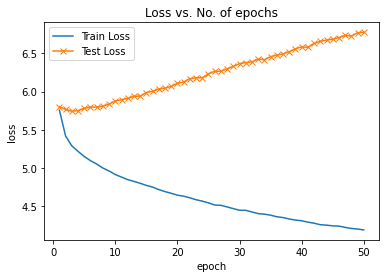

In [39]:
plt.plot(metrics['epoch'], metrics['Train Loss'], label="Train Loss")
plt.plot(metrics['epoch'], metrics['Valid Loss'], '-x', label="Test Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.title('Loss vs. No. of epochs');

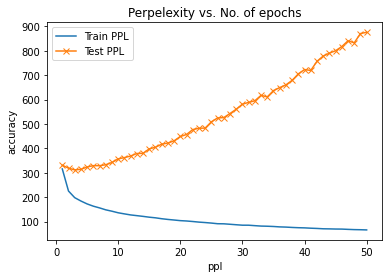

In [40]:
plt.plot(metrics['epoch'], metrics['Train PPL'], label="Train PPL")
plt.plot(metrics['epoch'], metrics['Valid PPL'], '-x', label="Test PPL")
plt.xlabel('ppl')
plt.ylabel('accuracy')
plt.legend()
plt.title('Perpelexity vs. No. of epochs');

## Inference on Random Samples from Test Data

In [41]:
model.to(device)
model.eval()

Seq2Seq(
  (loss): CrossEntropyLoss()
  (encoder): Encoder(
    (embedding): Embedding(8892, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(8892, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=8892, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [42]:
samp_que = ['What is your name?', 'How can I help you?', 'Are you feeling well', 'I do not think you are qualified for this position', 'Please mind your own business']

In [ ]:
for i in range(len(samp_que)):
  src_sent = samp_que[i]
  trg_sent_tensor = torch.tensor([en_vocab[token] for token in en_tokenizer(src_sent)], dtype=torch.long).unsqueeze(1).to(device)   
  src_sent_tensor = torch.tensor([en_vocab[token] for token in en_tokenizer(src_sent)], dtype=torch.long).unsqueeze(1).to(device)   
  with torch.no_grad():
        output = model(src_sent_tensor, trg_sent_tensor, 1)
        out = output.squeeze(1)
        out = torch.argmax(out,dim=1)
        trans = []
        for c in out[1:]:
          trans.append(en_vocab_itos[c])
        st = " ".join(trans)
        start = "\033[1m"
        end = "\033[0;0m"
        print(f'{start}You: {end}{src_sent}')
        print(f'{start}Bot: {end}{st}')
        print()

You: What is your name?
Bot: ! n't friend 's

You: How can I help you?
Bot: ! not   me !

You: Are you feeling well
Bot: ! are n't

You: I do not think you are qualified for this position
Bot: ! n't be i are a   a is

You: Please mind your own business
Bot: !   arm wrigley

